# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [19]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.389737
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [20]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.641340 analytic: -0.641340, relative error: 1.506883e-08
numerical: -0.010003 analytic: -0.010003, relative error: 2.795222e-06
numerical: -0.931224 analytic: -0.931224, relative error: 1.112500e-09
numerical: 5.497173 analytic: 5.497173, relative error: 1.381852e-08
numerical: 1.769021 analytic: 1.769021, relative error: 7.679968e-09
numerical: -0.175865 analytic: -0.175865, relative error: 9.618376e-08
numerical: 2.201989 analytic: 2.201989, relative error: 1.375673e-08
numerical: -1.213086 analytic: -1.213086, relative error: 2.448342e-08
numerical: 1.680312 analytic: 1.680312, relative error: 8.085596e-09
numerical: -1.093710 analytic: -1.093710, relative error: 9.963322e-09
numerical: 2.067876 analytic: 2.067876, relative error: 3.833581e-08
numerical: -0.352411 analytic: -0.352411, relative error: 6.593495e-08
numerical: -0.490671 analytic: -0.490671, relative error: 2.357455e-08
numerical: 1.578729 analytic: 1.578729, relative error: 1.045418e-08
numerical: 0.09524

In [28]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.389737e+00 computed in 0.281843s
vectorized loss: 2.389737e+00 computed in 0.011399s
Loss difference: 0.000000
Gradient difference: 0.000000


In [34]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [-7, -6]
regularization_strengths = [4.2, 4.7]

n_points = 50

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
import random
from tqdm import tqdm

for __ in tqdm(range(n_points)):
    lr = 10**random.uniform(learning_rates[0], learning_rates[-1])
    r = 10**random.uniform(regularization_strengths[0], regularization_strengths[-1])
    softmax = Softmax()
    softmax.train(X_train, y_train, learning_rate=lr, reg=r,
                  num_iters=5000, verbose=True)
    y_train_pred = softmax.predict(X_train)
    acc_tr = np.mean(y_train == y_train_pred)
    y_val_pred = softmax.predict(X_val)
    acc = np.mean(y_val == y_val_pred)
    if acc > best_val:
        best_val = acc
        best_softmax = softmax
    results[lr,r] = [acc_tr, acc]
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


  0%|          | 0/50 [00:00<?, ?it/s]

iteration 0 / 5000: loss 979.177070
iteration 100 / 5000: loss 2.275389
iteration 200 / 5000: loss 2.177235
iteration 300 / 5000: loss 2.159611
iteration 400 / 5000: loss 2.074882
iteration 500 / 5000: loss 2.102919
iteration 600 / 5000: loss 2.073061
iteration 700 / 5000: loss 2.101845
iteration 800 / 5000: loss 2.160585
iteration 900 / 5000: loss 2.199714
iteration 1000 / 5000: loss 2.063867
iteration 1100 / 5000: loss 2.151420
iteration 1200 / 5000: loss 2.123039
iteration 1300 / 5000: loss 2.080241
iteration 1400 / 5000: loss 2.109586
iteration 1500 / 5000: loss 2.155760
iteration 1600 / 5000: loss 2.111534
iteration 1700 / 5000: loss 2.053014
iteration 1800 / 5000: loss 2.103996
iteration 1900 / 5000: loss 2.128814
iteration 2000 / 5000: loss 2.175843
iteration 2100 / 5000: loss 2.155338
iteration 2200 / 5000: loss 2.119367
iteration 2300 / 5000: loss 2.036227
iteration 2400 / 5000: loss 2.163935
iteration 2500 / 5000: loss 2.154829
iteration 2600 / 5000: loss 2.134813
iteration 2


  2%|▏         | 1/50 [00:39<32:17, 39.54s/it]

iteration 0 / 5000: loss 994.547868
iteration 100 / 5000: loss 2.462375
iteration 200 / 5000: loss 2.084955
iteration 300 / 5000: loss 2.099155
iteration 400 / 5000: loss 2.157966
iteration 500 / 5000: loss 2.123094
iteration 600 / 5000: loss 2.137115
iteration 700 / 5000: loss 2.101366
iteration 800 / 5000: loss 2.137940
iteration 900 / 5000: loss 2.134885
iteration 1000 / 5000: loss 2.130627
iteration 1100 / 5000: loss 2.117720
iteration 1200 / 5000: loss 2.089474
iteration 1300 / 5000: loss 2.079600
iteration 1400 / 5000: loss 2.137095
iteration 1500 / 5000: loss 2.160907
iteration 1600 / 5000: loss 2.155051
iteration 1700 / 5000: loss 2.110549
iteration 1800 / 5000: loss 2.101808
iteration 1900 / 5000: loss 2.111972
iteration 2000 / 5000: loss 2.077877
iteration 2100 / 5000: loss 2.200947
iteration 2200 / 5000: loss 2.152299
iteration 2300 / 5000: loss 2.104822
iteration 2400 / 5000: loss 2.110177
iteration 2500 / 5000: loss 2.060208
iteration 2600 / 5000: loss 2.119262
iteration 2


  4%|▍         | 2/50 [01:11<28:38, 35.80s/it]

iteration 0 / 5000: loss 1303.418173
iteration 100 / 5000: loss 2.139424
iteration 200 / 5000: loss 2.099782
iteration 300 / 5000: loss 2.160238
iteration 400 / 5000: loss 2.168006
iteration 500 / 5000: loss 2.108503
iteration 600 / 5000: loss 2.155467
iteration 700 / 5000: loss 2.138136
iteration 800 / 5000: loss 2.151273
iteration 900 / 5000: loss 2.131764
iteration 1000 / 5000: loss 2.127975
iteration 1100 / 5000: loss 2.114101
iteration 1200 / 5000: loss 2.107372
iteration 1300 / 5000: loss 2.157415
iteration 1400 / 5000: loss 2.134489
iteration 1500 / 5000: loss 2.107706
iteration 1600 / 5000: loss 2.137461
iteration 1700 / 5000: loss 2.142921
iteration 1800 / 5000: loss 2.105078
iteration 1900 / 5000: loss 2.143049
iteration 2000 / 5000: loss 2.096221
iteration 2100 / 5000: loss 2.090590
iteration 2200 / 5000: loss 2.155473
iteration 2300 / 5000: loss 2.117272
iteration 2400 / 5000: loss 2.082443
iteration 2500 / 5000: loss 2.116282
iteration 2600 / 5000: loss 2.170967
iteration 


  6%|▌         | 3/50 [01:44<27:15, 34.80s/it]

iteration 0 / 5000: loss 1123.229253
iteration 100 / 5000: loss 2.121554
iteration 200 / 5000: loss 2.162520
iteration 300 / 5000: loss 2.104881
iteration 400 / 5000: loss 2.163413
iteration 500 / 5000: loss 2.158080
iteration 600 / 5000: loss 2.123891
iteration 700 / 5000: loss 2.116639
iteration 800 / 5000: loss 2.123347
iteration 900 / 5000: loss 2.157111
iteration 1000 / 5000: loss 2.111837
iteration 1100 / 5000: loss 2.122925
iteration 1200 / 5000: loss 2.157375
iteration 1300 / 5000: loss 2.118248
iteration 1400 / 5000: loss 2.142293
iteration 1500 / 5000: loss 2.098664
iteration 1600 / 5000: loss 2.163052
iteration 1700 / 5000: loss 2.144038
iteration 1800 / 5000: loss 2.153837
iteration 1900 / 5000: loss 2.133310
iteration 2000 / 5000: loss 2.180761
iteration 2100 / 5000: loss 2.171177
iteration 2200 / 5000: loss 2.116312
iteration 2300 / 5000: loss 2.154898
iteration 2400 / 5000: loss 2.111991
iteration 2500 / 5000: loss 2.117673
iteration 2600 / 5000: loss 2.123851
iteration 


  8%|▊         | 4/50 [02:17<26:19, 34.34s/it]

iteration 0 / 5000: loss 1310.394113
iteration 100 / 5000: loss 7.396658
iteration 200 / 5000: loss 2.224821
iteration 300 / 5000: loss 2.098866
iteration 400 / 5000: loss 2.097737
iteration 500 / 5000: loss 2.158907
iteration 600 / 5000: loss 2.112738
iteration 700 / 5000: loss 2.160389
iteration 800 / 5000: loss 2.145921
iteration 900 / 5000: loss 2.121456
iteration 1000 / 5000: loss 2.185911
iteration 1100 / 5000: loss 2.149455
iteration 1200 / 5000: loss 2.116525
iteration 1300 / 5000: loss 2.129231
iteration 1400 / 5000: loss 2.135823
iteration 1500 / 5000: loss 2.098330
iteration 1600 / 5000: loss 2.133951
iteration 1700 / 5000: loss 2.065221
iteration 1800 / 5000: loss 2.101670
iteration 1900 / 5000: loss 2.145398
iteration 2000 / 5000: loss 2.159864
iteration 2100 / 5000: loss 2.168037
iteration 2200 / 5000: loss 2.096486
iteration 2300 / 5000: loss 2.084857
iteration 2400 / 5000: loss 2.232294
iteration 2500 / 5000: loss 2.160345
iteration 2600 / 5000: loss 2.125962
iteration 


 10%|█         | 5/50 [02:49<25:29, 34.00s/it]

iteration 0 / 5000: loss 1008.045017
iteration 100 / 5000: loss 2.095771
iteration 200 / 5000: loss 2.141976
iteration 300 / 5000: loss 2.051020
iteration 400 / 5000: loss 2.102944
iteration 500 / 5000: loss 2.100574
iteration 600 / 5000: loss 2.093017
iteration 700 / 5000: loss 2.175996
iteration 800 / 5000: loss 2.149513
iteration 900 / 5000: loss 2.064503
iteration 1000 / 5000: loss 2.137650
iteration 1100 / 5000: loss 2.129987
iteration 1200 / 5000: loss 2.148293
iteration 1300 / 5000: loss 2.079563
iteration 1400 / 5000: loss 2.151501
iteration 1500 / 5000: loss 2.071024
iteration 1600 / 5000: loss 2.139373
iteration 1700 / 5000: loss 2.150404
iteration 1800 / 5000: loss 2.144088
iteration 1900 / 5000: loss 2.182502
iteration 2000 / 5000: loss 2.089800
iteration 2100 / 5000: loss 2.084987
iteration 2200 / 5000: loss 2.144656
iteration 2300 / 5000: loss 2.114051
iteration 2400 / 5000: loss 2.098259
iteration 2500 / 5000: loss 2.088087
iteration 2600 / 5000: loss 2.089278
iteration 


 12%|█▏        | 6/50 [03:22<24:46, 33.79s/it]

iteration 0 / 5000: loss 958.988959
iteration 100 / 5000: loss 2.191759
iteration 200 / 5000: loss 2.078888
iteration 300 / 5000: loss 2.159583
iteration 400 / 5000: loss 2.128137
iteration 500 / 5000: loss 2.115926
iteration 600 / 5000: loss 2.131551
iteration 700 / 5000: loss 2.113164
iteration 800 / 5000: loss 2.092195
iteration 900 / 5000: loss 2.116950
iteration 1000 / 5000: loss 2.064943
iteration 1100 / 5000: loss 2.138578
iteration 1200 / 5000: loss 2.145620
iteration 1300 / 5000: loss 2.130554
iteration 1400 / 5000: loss 2.124577
iteration 1500 / 5000: loss 2.125376
iteration 1600 / 5000: loss 2.117575
iteration 1700 / 5000: loss 2.151894
iteration 1800 / 5000: loss 2.122592
iteration 1900 / 5000: loss 2.087553
iteration 2000 / 5000: loss 2.143419
iteration 2100 / 5000: loss 2.058086
iteration 2200 / 5000: loss 2.130477
iteration 2300 / 5000: loss 2.069828
iteration 2400 / 5000: loss 2.120830
iteration 2500 / 5000: loss 2.084630
iteration 2600 / 5000: loss 2.062777
iteration 2


 14%|█▍        | 7/50 [03:54<24:01, 33.53s/it]

iteration 0 / 5000: loss 599.331631
iteration 100 / 5000: loss 42.495211
iteration 200 / 5000: loss 4.818585
iteration 300 / 5000: loss 2.209457
iteration 400 / 5000: loss 2.123215
iteration 500 / 5000: loss 2.062336
iteration 600 / 5000: loss 2.088251
iteration 700 / 5000: loss 2.020768
iteration 800 / 5000: loss 2.070628
iteration 900 / 5000: loss 2.105532
iteration 1000 / 5000: loss 2.077367
iteration 1100 / 5000: loss 2.074301
iteration 1200 / 5000: loss 2.086513
iteration 1300 / 5000: loss 2.025959
iteration 1400 / 5000: loss 2.045367
iteration 1500 / 5000: loss 2.087624
iteration 1600 / 5000: loss 2.075173
iteration 1700 / 5000: loss 2.080326
iteration 1800 / 5000: loss 2.073435
iteration 1900 / 5000: loss 2.089229
iteration 2000 / 5000: loss 2.087130
iteration 2100 / 5000: loss 2.057695
iteration 2200 / 5000: loss 2.048933
iteration 2300 / 5000: loss 2.073082
iteration 2400 / 5000: loss 2.114783
iteration 2500 / 5000: loss 2.068182
iteration 2600 / 5000: loss 2.079487
iteration 


 16%|█▌        | 8/50 [04:27<23:25, 33.47s/it]

iteration 0 / 5000: loss 729.582128
iteration 100 / 5000: loss 120.595123
iteration 200 / 5000: loss 21.413727
iteration 300 / 5000: loss 5.256270
iteration 400 / 5000: loss 2.597574
iteration 500 / 5000: loss 2.193696
iteration 600 / 5000: loss 2.063432
iteration 700 / 5000: loss 2.126754
iteration 800 / 5000: loss 2.067751
iteration 900 / 5000: loss 2.083489
iteration 1000 / 5000: loss 2.077184
iteration 1100 / 5000: loss 2.032148
iteration 1200 / 5000: loss 2.081408
iteration 1300 / 5000: loss 2.080582
iteration 1400 / 5000: loss 2.076740
iteration 1500 / 5000: loss 2.116990
iteration 1600 / 5000: loss 2.058509
iteration 1700 / 5000: loss 2.049587
iteration 1800 / 5000: loss 2.066490
iteration 1900 / 5000: loss 2.111963
iteration 2000 / 5000: loss 2.111224
iteration 2100 / 5000: loss 2.039895
iteration 2200 / 5000: loss 2.108876
iteration 2300 / 5000: loss 2.061191
iteration 2400 / 5000: loss 2.062848
iteration 2500 / 5000: loss 2.099192
iteration 2600 / 5000: loss 2.063311
iteratio


 18%|█▊        | 9/50 [04:59<22:46, 33.33s/it]

iteration 0 / 5000: loss 597.771983
iteration 100 / 5000: loss 9.219007
iteration 200 / 5000: loss 2.203315
iteration 300 / 5000: loss 2.021861
iteration 400 / 5000: loss 2.084029
iteration 500 / 5000: loss 2.086776
iteration 600 / 5000: loss 2.015648
iteration 700 / 5000: loss 2.058647
iteration 800 / 5000: loss 2.109667
iteration 900 / 5000: loss 2.040024
iteration 1000 / 5000: loss 2.035009
iteration 1100 / 5000: loss 2.093676
iteration 1200 / 5000: loss 2.013373
iteration 1300 / 5000: loss 2.069042
iteration 1400 / 5000: loss 2.046324
iteration 1500 / 5000: loss 2.052126
iteration 1600 / 5000: loss 2.117181
iteration 1700 / 5000: loss 2.065755
iteration 1800 / 5000: loss 2.035433
iteration 1900 / 5000: loss 2.086988
iteration 2000 / 5000: loss 2.059760
iteration 2100 / 5000: loss 2.069357
iteration 2200 / 5000: loss 2.143317
iteration 2300 / 5000: loss 2.036089
iteration 2400 / 5000: loss 2.161500
iteration 2500 / 5000: loss 2.091972
iteration 2600 / 5000: loss 2.052018
iteration 2


 20%|██        | 10/50 [05:34<22:16, 33.42s/it]

iteration 0 / 5000: loss 776.308900
iteration 100 / 5000: loss 70.712952
iteration 200 / 5000: loss 8.278018
iteration 300 / 5000: loss 2.663842
iteration 400 / 5000: loss 2.119147
iteration 500 / 5000: loss 2.071185
iteration 600 / 5000: loss 2.101263
iteration 700 / 5000: loss 2.038321
iteration 800 / 5000: loss 2.093881
iteration 900 / 5000: loss 2.040557
iteration 1000 / 5000: loss 2.114752
iteration 1100 / 5000: loss 2.112796
iteration 1200 / 5000: loss 2.035729
iteration 1300 / 5000: loss 2.114651
iteration 1400 / 5000: loss 2.082441
iteration 1500 / 5000: loss 2.109737
iteration 1600 / 5000: loss 2.042839
iteration 1700 / 5000: loss 2.070948
iteration 1800 / 5000: loss 2.040741
iteration 1900 / 5000: loss 2.051760
iteration 2000 / 5000: loss 2.046720
iteration 2100 / 5000: loss 2.072192
iteration 2200 / 5000: loss 2.117224
iteration 2300 / 5000: loss 2.119774
iteration 2400 / 5000: loss 2.110385
iteration 2500 / 5000: loss 2.044842
iteration 2600 / 5000: loss 2.018171
iteration 


 22%|██▏       | 11/50 [06:09<21:49, 33.57s/it]

iteration 0 / 5000: loss 628.878049
iteration 100 / 5000: loss 246.609929
iteration 200 / 5000: loss 97.508494
iteration 300 / 5000: loss 39.571021
iteration 400 / 5000: loss 16.636844
iteration 500 / 5000: loss 7.798117
iteration 600 / 5000: loss 4.332154
iteration 700 / 5000: loss 2.906807
iteration 800 / 5000: loss 2.429694
iteration 900 / 5000: loss 2.250907
iteration 1000 / 5000: loss 2.139984
iteration 1100 / 5000: loss 2.118374
iteration 1200 / 5000: loss 2.125409
iteration 1300 / 5000: loss 2.064804
iteration 1400 / 5000: loss 2.016134
iteration 1500 / 5000: loss 2.053786
iteration 1600 / 5000: loss 1.981966
iteration 1700 / 5000: loss 2.038869
iteration 1800 / 5000: loss 2.098067
iteration 1900 / 5000: loss 2.064171
iteration 2000 / 5000: loss 2.018825
iteration 2100 / 5000: loss 1.994011
iteration 2200 / 5000: loss 2.065234
iteration 2300 / 5000: loss 2.052272
iteration 2400 / 5000: loss 2.125984
iteration 2500 / 5000: loss 2.103001
iteration 2600 / 5000: loss 2.114465
iterat


 24%|██▍       | 12/50 [06:45<21:24, 33.80s/it]

iteration 0 / 5000: loss 611.214819
iteration 100 / 5000: loss 246.818789
iteration 200 / 5000: loss 100.433136
iteration 300 / 5000: loss 41.706379
iteration 400 / 5000: loss 17.890989
iteration 500 / 5000: loss 8.444670
iteration 600 / 5000: loss 4.655013
iteration 700 / 5000: loss 3.140203
iteration 800 / 5000: loss 2.468196
iteration 900 / 5000: loss 2.257656
iteration 1000 / 5000: loss 2.148365
iteration 1100 / 5000: loss 2.120480
iteration 1200 / 5000: loss 2.098670
iteration 1300 / 5000: loss 2.040298
iteration 1400 / 5000: loss 2.114791
iteration 1500 / 5000: loss 2.032614
iteration 1600 / 5000: loss 2.021661
iteration 1700 / 5000: loss 2.082434
iteration 1800 / 5000: loss 2.043504
iteration 1900 / 5000: loss 2.042308
iteration 2000 / 5000: loss 2.070208
iteration 2100 / 5000: loss 2.022227
iteration 2200 / 5000: loss 2.046505
iteration 2300 / 5000: loss 2.125910
iteration 2400 / 5000: loss 2.136293
iteration 2500 / 5000: loss 2.093281
iteration 2600 / 5000: loss 2.056377
itera


 26%|██▌       | 13/50 [07:20<20:54, 33.89s/it]

iteration 0 / 5000: loss 897.263044
iteration 100 / 5000: loss 102.801983
iteration 200 / 5000: loss 13.446804
iteration 300 / 5000: loss 3.319814
iteration 400 / 5000: loss 2.222177
iteration 500 / 5000: loss 2.052125
iteration 600 / 5000: loss 2.078972
iteration 700 / 5000: loss 2.062697
iteration 800 / 5000: loss 2.066009
iteration 900 / 5000: loss 2.104363
iteration 1000 / 5000: loss 2.101780
iteration 1100 / 5000: loss 2.133828
iteration 1200 / 5000: loss 2.105122
iteration 1300 / 5000: loss 2.059204
iteration 1400 / 5000: loss 2.083710
iteration 1500 / 5000: loss 2.047828
iteration 1600 / 5000: loss 2.118895
iteration 1700 / 5000: loss 2.085447
iteration 1800 / 5000: loss 2.130769
iteration 1900 / 5000: loss 2.061909
iteration 2000 / 5000: loss 2.139024
iteration 2100 / 5000: loss 2.122423
iteration 2200 / 5000: loss 2.084407
iteration 2300 / 5000: loss 2.112154
iteration 2400 / 5000: loss 2.111736
iteration 2500 / 5000: loss 2.121892
iteration 2600 / 5000: loss 2.097860
iteratio


 28%|██▊       | 14/50 [07:56<20:24, 34.01s/it]

iteration 0 / 5000: loss 1016.748406
iteration 100 / 5000: loss 159.718195
iteration 200 / 5000: loss 26.688810
iteration 300 / 5000: loss 5.953804
iteration 400 / 5000: loss 2.757842
iteration 500 / 5000: loss 2.182051
iteration 600 / 5000: loss 2.086445
iteration 700 / 5000: loss 2.115117
iteration 800 / 5000: loss 2.098956
iteration 900 / 5000: loss 2.144187
iteration 1000 / 5000: loss 2.077173
iteration 1100 / 5000: loss 2.129665
iteration 1200 / 5000: loss 2.102852
iteration 1300 / 5000: loss 2.147753
iteration 1400 / 5000: loss 2.140375
iteration 1500 / 5000: loss 2.063405
iteration 1600 / 5000: loss 2.057020
iteration 1700 / 5000: loss 2.133566
iteration 1800 / 5000: loss 2.110058
iteration 1900 / 5000: loss 2.128390
iteration 2000 / 5000: loss 2.113809
iteration 2100 / 5000: loss 2.102695
iteration 2200 / 5000: loss 2.076760
iteration 2300 / 5000: loss 2.152501
iteration 2400 / 5000: loss 2.082778
iteration 2500 / 5000: loss 2.131761
iteration 2600 / 5000: loss 2.119604
iterati


 30%|███       | 15/50 [08:29<19:48, 33.95s/it]

iteration 0 / 5000: loss 1541.456471
iteration 100 / 5000: loss 3.028370
iteration 200 / 5000: loss 2.114370
iteration 300 / 5000: loss 2.130399
iteration 400 / 5000: loss 2.181542
iteration 500 / 5000: loss 2.127915
iteration 600 / 5000: loss 2.138920
iteration 700 / 5000: loss 2.143470
iteration 800 / 5000: loss 2.164006
iteration 900 / 5000: loss 2.176408
iteration 1000 / 5000: loss 2.115753
iteration 1100 / 5000: loss 2.145734
iteration 1200 / 5000: loss 2.149839
iteration 1300 / 5000: loss 2.139179
iteration 1400 / 5000: loss 2.083742
iteration 1500 / 5000: loss 2.124598
iteration 1600 / 5000: loss 2.103289
iteration 1700 / 5000: loss 2.168548
iteration 1800 / 5000: loss 2.142369
iteration 1900 / 5000: loss 2.115974
iteration 2000 / 5000: loss 2.142955
iteration 2100 / 5000: loss 2.220529
iteration 2200 / 5000: loss 2.158228
iteration 2300 / 5000: loss 2.170080
iteration 2400 / 5000: loss 2.144334
iteration 2500 / 5000: loss 2.164655
iteration 2600 / 5000: loss 2.198175
iteration 


 32%|███▏      | 16/50 [09:01<19:09, 33.82s/it]

iteration 0 / 5000: loss 1181.735294
iteration 100 / 5000: loss 63.568314
iteration 200 / 5000: loss 5.339268
iteration 300 / 5000: loss 2.249518
iteration 400 / 5000: loss 2.149523
iteration 500 / 5000: loss 2.153682
iteration 600 / 5000: loss 2.095926
iteration 700 / 5000: loss 2.128302
iteration 800 / 5000: loss 2.135048
iteration 900 / 5000: loss 2.096005
iteration 1000 / 5000: loss 2.097670
iteration 1100 / 5000: loss 2.199379
iteration 1200 / 5000: loss 2.184747
iteration 1300 / 5000: loss 2.168222
iteration 1400 / 5000: loss 2.098018
iteration 1500 / 5000: loss 2.099745
iteration 1600 / 5000: loss 2.133365
iteration 1700 / 5000: loss 2.120094
iteration 1800 / 5000: loss 2.095655
iteration 1900 / 5000: loss 2.101326
iteration 2000 / 5000: loss 2.101671
iteration 2100 / 5000: loss 2.128816
iteration 2200 / 5000: loss 2.096544
iteration 2300 / 5000: loss 2.171596
iteration 2400 / 5000: loss 2.100368
iteration 2500 / 5000: loss 2.088485
iteration 2600 / 5000: loss 2.085528
iteration


 34%|███▍      | 17/50 [09:33<18:33, 33.74s/it]

iteration 0 / 5000: loss 717.383443
iteration 100 / 5000: loss 211.485772
iteration 200 / 5000: loss 63.460899
iteration 300 / 5000: loss 20.138083
iteration 400 / 5000: loss 7.344468
iteration 500 / 5000: loss 3.662695
iteration 600 / 5000: loss 2.518640
iteration 700 / 5000: loss 2.209111
iteration 800 / 5000: loss 2.163977
iteration 900 / 5000: loss 2.111022
iteration 1000 / 5000: loss 2.118877
iteration 1100 / 5000: loss 2.121944
iteration 1200 / 5000: loss 2.141336
iteration 1300 / 5000: loss 2.024594
iteration 1400 / 5000: loss 2.033275
iteration 1500 / 5000: loss 2.126450
iteration 1600 / 5000: loss 2.057799
iteration 1700 / 5000: loss 2.087858
iteration 1800 / 5000: loss 2.092429
iteration 1900 / 5000: loss 2.131730
iteration 2000 / 5000: loss 2.045026
iteration 2100 / 5000: loss 2.087352
iteration 2200 / 5000: loss 2.093551
iteration 2300 / 5000: loss 2.096730
iteration 2400 / 5000: loss 2.130675
iteration 2500 / 5000: loss 2.082983
iteration 2600 / 5000: loss 2.061521
iterati


 36%|███▌      | 18/50 [10:05<17:56, 33.63s/it]

iteration 0 / 5000: loss 876.338950
iteration 100 / 5000: loss 52.739486
iteration 200 / 5000: loss 5.040007
iteration 300 / 5000: loss 2.304399
iteration 400 / 5000: loss 2.078091
iteration 500 / 5000: loss 2.104631
iteration 600 / 5000: loss 2.054968
iteration 700 / 5000: loss 2.086355
iteration 800 / 5000: loss 2.036738
iteration 900 / 5000: loss 2.100032
iteration 1000 / 5000: loss 2.160720
iteration 1100 / 5000: loss 2.162353
iteration 1200 / 5000: loss 2.112524
iteration 1300 / 5000: loss 2.107935
iteration 1400 / 5000: loss 2.094391
iteration 1500 / 5000: loss 2.096405
iteration 1600 / 5000: loss 2.058158
iteration 1700 / 5000: loss 2.132862
iteration 1800 / 5000: loss 2.053786
iteration 1900 / 5000: loss 2.123924
iteration 2000 / 5000: loss 2.143183
iteration 2100 / 5000: loss 2.058362
iteration 2200 / 5000: loss 2.035741
iteration 2300 / 5000: loss 2.069736
iteration 2400 / 5000: loss 2.055748
iteration 2500 / 5000: loss 2.102892
iteration 2600 / 5000: loss 2.092591
iteration 


 38%|███▊      | 19/50 [10:42<17:27, 33.80s/it]

iteration 0 / 5000: loss 657.721107
iteration 100 / 5000: loss 19.979581
iteration 200 / 5000: loss 2.540453
iteration 300 / 5000: loss 2.060325
iteration 400 / 5000: loss 2.059901
iteration 500 / 5000: loss 2.102609
iteration 600 / 5000: loss 2.105195
iteration 700 / 5000: loss 2.100022
iteration 800 / 5000: loss 2.072578
iteration 900 / 5000: loss 2.058272
iteration 1000 / 5000: loss 2.055194
iteration 1100 / 5000: loss 2.105394
iteration 1200 / 5000: loss 2.085281
iteration 1300 / 5000: loss 2.114060
iteration 1400 / 5000: loss 2.076420
iteration 1500 / 5000: loss 2.106486
iteration 1600 / 5000: loss 2.072990
iteration 1700 / 5000: loss 2.175947
iteration 1800 / 5000: loss 2.107607
iteration 1900 / 5000: loss 2.076820
iteration 2000 / 5000: loss 2.146927
iteration 2100 / 5000: loss 2.115315
iteration 2200 / 5000: loss 2.102560
iteration 2300 / 5000: loss 2.026077
iteration 2400 / 5000: loss 2.083491
iteration 2500 / 5000: loss 2.067131
iteration 2600 / 5000: loss 2.096717
iteration 


 40%|████      | 20/50 [11:13<16:50, 33.68s/it]

iteration 0 / 5000: loss 1088.680257
iteration 100 / 5000: loss 28.787431
iteration 200 / 5000: loss 2.800442
iteration 300 / 5000: loss 2.130218
iteration 400 / 5000: loss 2.138721
iteration 500 / 5000: loss 2.131341
iteration 600 / 5000: loss 2.079238
iteration 700 / 5000: loss 2.161587
iteration 800 / 5000: loss 2.121084
iteration 900 / 5000: loss 2.093572
iteration 1000 / 5000: loss 2.115151
iteration 1100 / 5000: loss 2.098554
iteration 1200 / 5000: loss 2.113904
iteration 1300 / 5000: loss 2.065333
iteration 1400 / 5000: loss 2.069262
iteration 1500 / 5000: loss 2.136550
iteration 1600 / 5000: loss 2.119153
iteration 1700 / 5000: loss 2.137927
iteration 1800 / 5000: loss 2.074369
iteration 1900 / 5000: loss 2.142429
iteration 2000 / 5000: loss 2.108314
iteration 2100 / 5000: loss 2.112104
iteration 2200 / 5000: loss 2.134132
iteration 2300 / 5000: loss 2.109897
iteration 2400 / 5000: loss 2.128292
iteration 2500 / 5000: loss 2.126252
iteration 2600 / 5000: loss 2.081120
iteration


 42%|████▏     | 21/50 [11:45<16:14, 33.59s/it]

iteration 0 / 5000: loss 1460.017617
iteration 100 / 5000: loss 2.169170
iteration 200 / 5000: loss 2.164223
iteration 300 / 5000: loss 2.150606
iteration 400 / 5000: loss 2.170887
iteration 500 / 5000: loss 2.106009
iteration 600 / 5000: loss 2.153817
iteration 700 / 5000: loss 2.218116
iteration 800 / 5000: loss 2.127439
iteration 900 / 5000: loss 2.095973
iteration 1000 / 5000: loss 2.147303
iteration 1100 / 5000: loss 2.086799
iteration 1200 / 5000: loss 2.119157
iteration 1300 / 5000: loss 2.151298
iteration 1400 / 5000: loss 2.155259
iteration 1500 / 5000: loss 2.172109
iteration 1600 / 5000: loss 2.131522
iteration 1700 / 5000: loss 2.121223
iteration 1800 / 5000: loss 2.168820
iteration 1900 / 5000: loss 2.118720
iteration 2000 / 5000: loss 2.202616
iteration 2100 / 5000: loss 2.152517
iteration 2200 / 5000: loss 2.136055
iteration 2300 / 5000: loss 2.152028
iteration 2400 / 5000: loss 2.143983
iteration 2500 / 5000: loss 2.107680
iteration 2600 / 5000: loss 2.143436
iteration 


 44%|████▍     | 22/50 [12:17<15:38, 33.51s/it]

iteration 0 / 5000: loss 1063.996814
iteration 100 / 5000: loss 26.539566
iteration 200 / 5000: loss 2.688047
iteration 300 / 5000: loss 2.118872
iteration 400 / 5000: loss 2.134956
iteration 500 / 5000: loss 2.155221
iteration 600 / 5000: loss 2.134023
iteration 700 / 5000: loss 2.095019
iteration 800 / 5000: loss 2.089895
iteration 900 / 5000: loss 2.111240
iteration 1000 / 5000: loss 2.118660
iteration 1100 / 5000: loss 2.115416
iteration 1200 / 5000: loss 2.135765
iteration 1300 / 5000: loss 2.093349
iteration 1400 / 5000: loss 2.090500
iteration 1500 / 5000: loss 2.141986
iteration 1600 / 5000: loss 2.127849
iteration 1700 / 5000: loss 2.108829
iteration 1800 / 5000: loss 2.103807
iteration 1900 / 5000: loss 2.167316
iteration 2000 / 5000: loss 2.062995
iteration 2100 / 5000: loss 2.080248
iteration 2200 / 5000: loss 2.106688
iteration 2300 / 5000: loss 2.090699
iteration 2400 / 5000: loss 2.085307
iteration 2500 / 5000: loss 2.174543
iteration 2600 / 5000: loss 2.088340
iteration


 46%|████▌     | 23/50 [12:49<15:03, 33.46s/it]

iteration 0 / 5000: loss 1242.648792
iteration 100 / 5000: loss 2.112374
iteration 200 / 5000: loss 2.166673
iteration 300 / 5000: loss 2.163484
iteration 400 / 5000: loss 2.106262
iteration 500 / 5000: loss 2.142121
iteration 600 / 5000: loss 2.132318
iteration 700 / 5000: loss 2.162602
iteration 800 / 5000: loss 2.146994
iteration 900 / 5000: loss 2.090195
iteration 1000 / 5000: loss 2.114862
iteration 1100 / 5000: loss 2.131351
iteration 1200 / 5000: loss 2.145909
iteration 1300 / 5000: loss 2.183133
iteration 1400 / 5000: loss 2.109568
iteration 1500 / 5000: loss 2.113964
iteration 1600 / 5000: loss 2.151853
iteration 1700 / 5000: loss 2.121911
iteration 1800 / 5000: loss 2.133303
iteration 1900 / 5000: loss 2.214848
iteration 2000 / 5000: loss 2.131125
iteration 2100 / 5000: loss 2.153330
iteration 2200 / 5000: loss 2.145175
iteration 2300 / 5000: loss 2.113397
iteration 2400 / 5000: loss 2.116893
iteration 2500 / 5000: loss 2.167704
iteration 2600 / 5000: loss 2.121781
iteration 


 48%|████▊     | 24/50 [13:24<14:31, 33.50s/it]

iteration 0 / 5000: loss 551.067667
iteration 100 / 5000: loss 218.300554
iteration 200 / 5000: loss 87.383894
iteration 300 / 5000: loss 35.801545
iteration 400 / 5000: loss 15.449076
iteration 500 / 5000: loss 7.346006
iteration 600 / 5000: loss 4.212063
iteration 700 / 5000: loss 2.843136
iteration 800 / 5000: loss 2.361301
iteration 900 / 5000: loss 2.258998
iteration 1000 / 5000: loss 2.094868
iteration 1100 / 5000: loss 2.023618
iteration 1200 / 5000: loss 2.005529
iteration 1300 / 5000: loss 2.015515
iteration 1400 / 5000: loss 2.058425
iteration 1500 / 5000: loss 2.067010
iteration 1600 / 5000: loss 2.056608
iteration 1700 / 5000: loss 2.099716
iteration 1800 / 5000: loss 2.019606
iteration 1900 / 5000: loss 2.034469
iteration 2000 / 5000: loss 2.059421
iteration 2100 / 5000: loss 2.053396
iteration 2200 / 5000: loss 2.021813
iteration 2300 / 5000: loss 2.082617
iteration 2400 / 5000: loss 2.017663
iteration 2500 / 5000: loss 2.040133
iteration 2600 / 5000: loss 1.981205
iterat


 50%|█████     | 25/50 [14:04<14:04, 33.77s/it]

iteration 0 / 5000: loss 1180.339271
iteration 100 / 5000: loss 110.998572
iteration 200 / 5000: loss 12.170395
iteration 300 / 5000: loss 3.080612
iteration 400 / 5000: loss 2.205700
iteration 500 / 5000: loss 2.115443
iteration 600 / 5000: loss 2.143248
iteration 700 / 5000: loss 2.143847
iteration 800 / 5000: loss 2.128916
iteration 900 / 5000: loss 2.143656
iteration 1000 / 5000: loss 2.167618
iteration 1100 / 5000: loss 2.142532
iteration 1200 / 5000: loss 2.088732
iteration 1300 / 5000: loss 2.091327
iteration 1400 / 5000: loss 2.090002
iteration 1500 / 5000: loss 2.102008
iteration 1600 / 5000: loss 2.097405
iteration 1700 / 5000: loss 2.089395
iteration 1800 / 5000: loss 2.088252
iteration 1900 / 5000: loss 2.156070
iteration 2000 / 5000: loss 2.111044
iteration 2100 / 5000: loss 2.114898
iteration 2200 / 5000: loss 2.174530
iteration 2300 / 5000: loss 2.119542
iteration 2400 / 5000: loss 2.116407
iteration 2500 / 5000: loss 2.092897
iteration 2600 / 5000: loss 2.157365
iterati


 52%|█████▏    | 26/50 [14:43<13:35, 33.99s/it]

iteration 0 / 5000: loss 552.149156
iteration 100 / 5000: loss 191.354172
iteration 200 / 5000: loss 67.444653
iteration 300 / 5000: loss 24.595917
iteration 400 / 5000: loss 9.860785
iteration 500 / 5000: loss 4.762646
iteration 600 / 5000: loss 2.932258
iteration 700 / 5000: loss 2.414862
iteration 800 / 5000: loss 2.179448
iteration 900 / 5000: loss 2.081942
iteration 1000 / 5000: loss 2.110262
iteration 1100 / 5000: loss 2.014077
iteration 1200 / 5000: loss 2.043837
iteration 1300 / 5000: loss 2.075325
iteration 1400 / 5000: loss 2.089165
iteration 1500 / 5000: loss 2.020267
iteration 1600 / 5000: loss 2.020982
iteration 1700 / 5000: loss 2.024280
iteration 1800 / 5000: loss 2.152077
iteration 1900 / 5000: loss 2.047754
iteration 2000 / 5000: loss 2.077270
iteration 2100 / 5000: loss 2.112440
iteration 2200 / 5000: loss 2.153144
iteration 2300 / 5000: loss 2.050502
iteration 2400 / 5000: loss 2.075729
iteration 2500 / 5000: loss 2.059069
iteration 2600 / 5000: loss 2.115491
iterati


 54%|█████▍    | 27/50 [15:22<13:06, 34.18s/it]

iteration 0 / 5000: loss 701.702747
iteration 100 / 5000: loss 123.150049
iteration 200 / 5000: loss 23.098524
iteration 300 / 5000: loss 5.719697
iteration 400 / 5000: loss 2.736338
iteration 500 / 5000: loss 2.160623
iteration 600 / 5000: loss 2.132302
iteration 700 / 5000: loss 2.100630
iteration 800 / 5000: loss 2.053936
iteration 900 / 5000: loss 2.078737
iteration 1000 / 5000: loss 2.109831
iteration 1100 / 5000: loss 2.059928
iteration 1200 / 5000: loss 2.079124
iteration 1300 / 5000: loss 2.123144
iteration 1400 / 5000: loss 2.053747
iteration 1500 / 5000: loss 2.063618
iteration 1600 / 5000: loss 2.083361
iteration 1700 / 5000: loss 2.131177
iteration 1800 / 5000: loss 2.035982
iteration 1900 / 5000: loss 2.036913
iteration 2000 / 5000: loss 2.086729
iteration 2100 / 5000: loss 2.125239
iteration 2200 / 5000: loss 2.065219
iteration 2300 / 5000: loss 2.081561
iteration 2400 / 5000: loss 2.027916
iteration 2500 / 5000: loss 2.066472
iteration 2600 / 5000: loss 2.076690
iteratio


 56%|█████▌    | 28/50 [16:02<12:36, 34.38s/it]

iteration 0 / 5000: loss 1372.128419
iteration 100 / 5000: loss 45.485215
iteration 200 / 5000: loss 3.464390
iteration 300 / 5000: loss 2.144148
iteration 400 / 5000: loss 2.105071
iteration 500 / 5000: loss 2.200544
iteration 600 / 5000: loss 2.146614
iteration 700 / 5000: loss 2.114993
iteration 800 / 5000: loss 2.196402
iteration 900 / 5000: loss 2.140241
iteration 1000 / 5000: loss 2.145487
iteration 1100 / 5000: loss 2.161734
iteration 1200 / 5000: loss 2.097391
iteration 1300 / 5000: loss 2.151726
iteration 1400 / 5000: loss 2.169021
iteration 1500 / 5000: loss 2.176981
iteration 1600 / 5000: loss 2.150009
iteration 1700 / 5000: loss 2.144577
iteration 1800 / 5000: loss 2.089755
iteration 1900 / 5000: loss 2.116120
iteration 2000 / 5000: loss 2.149102
iteration 2100 / 5000: loss 2.079098
iteration 2200 / 5000: loss 2.113905
iteration 2300 / 5000: loss 2.143996
iteration 2400 / 5000: loss 2.083719
iteration 2500 / 5000: loss 2.145534
iteration 2600 / 5000: loss 2.141393
iteration


 58%|█████▊    | 29/50 [16:38<12:03, 34.44s/it]

iteration 0 / 5000: loss 1481.111345
iteration 100 / 5000: loss 24.743901
iteration 200 / 5000: loss 2.499639
iteration 300 / 5000: loss 2.116303
iteration 400 / 5000: loss 2.155264
iteration 500 / 5000: loss 2.144720
iteration 600 / 5000: loss 2.118301
iteration 700 / 5000: loss 2.113768
iteration 800 / 5000: loss 2.166563
iteration 900 / 5000: loss 2.139326
iteration 1000 / 5000: loss 2.148867
iteration 1100 / 5000: loss 2.156356
iteration 1200 / 5000: loss 2.138859
iteration 1300 / 5000: loss 2.110857
iteration 1400 / 5000: loss 2.112597
iteration 1500 / 5000: loss 2.173994
iteration 1600 / 5000: loss 2.162767
iteration 1700 / 5000: loss 2.144512
iteration 1800 / 5000: loss 2.148719
iteration 1900 / 5000: loss 2.111390
iteration 2000 / 5000: loss 2.164987
iteration 2100 / 5000: loss 2.160143
iteration 2200 / 5000: loss 2.173507
iteration 2300 / 5000: loss 2.108545
iteration 2400 / 5000: loss 2.168232
iteration 2500 / 5000: loss 2.164030
iteration 2600 / 5000: loss 2.105026
iteration


 60%|██████    | 30/50 [17:12<11:28, 34.42s/it]

iteration 0 / 5000: loss 812.481137
iteration 100 / 5000: loss 4.550741
iteration 200 / 5000: loss 2.055764
iteration 300 / 5000: loss 2.118273
iteration 400 / 5000: loss 2.169503
iteration 500 / 5000: loss 2.100130
iteration 600 / 5000: loss 2.052640
iteration 700 / 5000: loss 2.118627
iteration 800 / 5000: loss 2.056925
iteration 900 / 5000: loss 2.101009
iteration 1000 / 5000: loss 2.128009
iteration 1100 / 5000: loss 2.072160
iteration 1200 / 5000: loss 2.152258
iteration 1300 / 5000: loss 2.109557
iteration 1400 / 5000: loss 2.106352
iteration 1500 / 5000: loss 2.084600
iteration 1600 / 5000: loss 2.085983
iteration 1700 / 5000: loss 2.114808
iteration 1800 / 5000: loss 2.075054
iteration 1900 / 5000: loss 2.036471
iteration 2000 / 5000: loss 2.047760
iteration 2100 / 5000: loss 2.126230
iteration 2200 / 5000: loss 2.142584
iteration 2300 / 5000: loss 2.106491
iteration 2400 / 5000: loss 2.053032
iteration 2500 / 5000: loss 2.033156
iteration 2600 / 5000: loss 2.092182
iteration 2


 62%|██████▏   | 31/50 [17:46<10:53, 34.40s/it]

iteration 0 / 5000: loss 1424.812710
iteration 100 / 5000: loss 119.694730
iteration 200 / 5000: loss 11.864861
iteration 300 / 5000: loss 2.961365
iteration 400 / 5000: loss 2.207706
iteration 500 / 5000: loss 2.137422
iteration 600 / 5000: loss 2.190128
iteration 700 / 5000: loss 2.162374
iteration 800 / 5000: loss 2.136148
iteration 900 / 5000: loss 2.154243
iteration 1000 / 5000: loss 2.121275
iteration 1100 / 5000: loss 2.111047
iteration 1200 / 5000: loss 2.141637
iteration 1300 / 5000: loss 2.132232
iteration 1400 / 5000: loss 2.160579
iteration 1500 / 5000: loss 2.095237
iteration 1600 / 5000: loss 2.123459
iteration 1700 / 5000: loss 2.119120
iteration 1800 / 5000: loss 2.086048
iteration 1900 / 5000: loss 2.141621
iteration 2000 / 5000: loss 2.126034
iteration 2100 / 5000: loss 2.158698
iteration 2200 / 5000: loss 2.134543
iteration 2300 / 5000: loss 2.156734
iteration 2400 / 5000: loss 2.185836
iteration 2500 / 5000: loss 2.122050
iteration 2600 / 5000: loss 2.217920
iterati


 64%|██████▍   | 32/50 [18:28<10:23, 34.63s/it]

iteration 0 / 5000: loss 592.134248
iteration 100 / 5000: loss 228.488915
iteration 200 / 5000: loss 89.164223
iteration 300 / 5000: loss 35.480838
iteration 400 / 5000: loss 14.956744
iteration 500 / 5000: loss 6.946031
iteration 600 / 5000: loss 4.017560
iteration 700 / 5000: loss 2.832779
iteration 800 / 5000: loss 2.360277
iteration 900 / 5000: loss 2.199759
iteration 1000 / 5000: loss 2.140693
iteration 1100 / 5000: loss 2.100477
iteration 1200 / 5000: loss 2.066879
iteration 1300 / 5000: loss 2.021376
iteration 1400 / 5000: loss 2.027394
iteration 1500 / 5000: loss 2.029190
iteration 1600 / 5000: loss 2.113108
iteration 1700 / 5000: loss 1.999629
iteration 1800 / 5000: loss 2.066138
iteration 1900 / 5000: loss 2.090845
iteration 2000 / 5000: loss 2.022721
iteration 2100 / 5000: loss 2.045559
iteration 2200 / 5000: loss 2.065684
iteration 2300 / 5000: loss 2.072336
iteration 2400 / 5000: loss 2.025871
iteration 2500 / 5000: loss 2.008230
iteration 2600 / 5000: loss 2.047602
iterat


 66%|██████▌   | 33/50 [19:00<09:47, 34.55s/it]

iteration 0 / 5000: loss 752.327234
iteration 100 / 5000: loss 30.610659
iteration 200 / 5000: loss 3.143253
iteration 300 / 5000: loss 2.105753
iteration 400 / 5000: loss 2.110787
iteration 500 / 5000: loss 2.049849
iteration 600 / 5000: loss 2.087877
iteration 700 / 5000: loss 2.047353
iteration 800 / 5000: loss 2.089748
iteration 900 / 5000: loss 2.108219
iteration 1000 / 5000: loss 2.066366
iteration 1100 / 5000: loss 2.063732
iteration 1200 / 5000: loss 2.090654
iteration 1300 / 5000: loss 2.095492
iteration 1400 / 5000: loss 2.070495
iteration 1500 / 5000: loss 2.088118
iteration 1600 / 5000: loss 2.016430
iteration 1700 / 5000: loss 2.081466
iteration 1800 / 5000: loss 2.047560
iteration 1900 / 5000: loss 2.149862
iteration 2000 / 5000: loss 2.073374
iteration 2100 / 5000: loss 2.048195
iteration 2200 / 5000: loss 2.001388
iteration 2300 / 5000: loss 2.106977
iteration 2400 / 5000: loss 2.107760
iteration 2500 / 5000: loss 2.112892
iteration 2600 / 5000: loss 2.085575
iteration 


 68%|██████▊   | 34/50 [19:39<09:15, 34.70s/it]

iteration 0 / 5000: loss 1101.406209
iteration 100 / 5000: loss 22.383568
iteration 200 / 5000: loss 2.468671
iteration 300 / 5000: loss 2.043096
iteration 400 / 5000: loss 2.116490
iteration 500 / 5000: loss 2.107480
iteration 600 / 5000: loss 2.130904
iteration 700 / 5000: loss 2.047602
iteration 800 / 5000: loss 2.057443
iteration 900 / 5000: loss 2.101140
iteration 1000 / 5000: loss 2.132464
iteration 1100 / 5000: loss 2.121017
iteration 1200 / 5000: loss 2.086257
iteration 1300 / 5000: loss 2.140581
iteration 1400 / 5000: loss 2.057179
iteration 1500 / 5000: loss 2.130934
iteration 1600 / 5000: loss 2.198419
iteration 1700 / 5000: loss 2.115243
iteration 1800 / 5000: loss 2.169165
iteration 1900 / 5000: loss 2.140378
iteration 2000 / 5000: loss 2.144108
iteration 2100 / 5000: loss 2.132381
iteration 2200 / 5000: loss 2.083766
iteration 2300 / 5000: loss 2.167589
iteration 2400 / 5000: loss 2.099914
iteration 2500 / 5000: loss 2.137337
iteration 2600 / 5000: loss 2.109067
iteration


 70%|███████   | 35/50 [20:19<08:42, 34.84s/it]

iteration 0 / 5000: loss 1497.273852
iteration 100 / 5000: loss 76.817173
iteration 200 / 5000: loss 5.918627
iteration 300 / 5000: loss 2.336630
iteration 400 / 5000: loss 2.174218
iteration 500 / 5000: loss 2.089967
iteration 600 / 5000: loss 2.110261
iteration 700 / 5000: loss 2.180923
iteration 800 / 5000: loss 2.175868
iteration 900 / 5000: loss 2.143756
iteration 1000 / 5000: loss 2.167015
iteration 1100 / 5000: loss 2.143376
iteration 1200 / 5000: loss 2.092205
iteration 1300 / 5000: loss 2.123354
iteration 1400 / 5000: loss 2.122324
iteration 1500 / 5000: loss 2.141650
iteration 1600 / 5000: loss 2.135614
iteration 1700 / 5000: loss 2.147884
iteration 1800 / 5000: loss 2.137171
iteration 1900 / 5000: loss 2.118325
iteration 2000 / 5000: loss 2.136343
iteration 2100 / 5000: loss 2.140678
iteration 2200 / 5000: loss 2.115610
iteration 2300 / 5000: loss 2.114387
iteration 2400 / 5000: loss 2.126409
iteration 2500 / 5000: loss 2.135048
iteration 2600 / 5000: loss 2.136017
iteration


 72%|███████▏  | 36/50 [20:54<08:07, 34.85s/it]

iteration 0 / 5000: loss 959.164308
iteration 100 / 5000: loss 52.946622
iteration 200 / 5000: loss 4.824810
iteration 300 / 5000: loss 2.200428
iteration 400 / 5000: loss 2.144914
iteration 500 / 5000: loss 2.118361
iteration 600 / 5000: loss 2.079816
iteration 700 / 5000: loss 2.133709
iteration 800 / 5000: loss 2.099072
iteration 900 / 5000: loss 2.105123
iteration 1000 / 5000: loss 2.154338
iteration 1100 / 5000: loss 2.105702
iteration 1200 / 5000: loss 2.073101
iteration 1300 / 5000: loss 2.143624
iteration 1400 / 5000: loss 2.132245
iteration 1500 / 5000: loss 2.114743
iteration 1600 / 5000: loss 2.091987
iteration 1700 / 5000: loss 2.076750
iteration 1800 / 5000: loss 2.074996
iteration 1900 / 5000: loss 2.062518
iteration 2000 / 5000: loss 2.140024
iteration 2100 / 5000: loss 2.056712
iteration 2200 / 5000: loss 2.078308
iteration 2300 / 5000: loss 2.108727
iteration 2400 / 5000: loss 2.046009
iteration 2500 / 5000: loss 2.102008
iteration 2600 / 5000: loss 2.095866
iteration 


 74%|███████▍  | 37/50 [21:31<07:33, 34.91s/it]

iteration 0 / 5000: loss 1354.580708
iteration 100 / 5000: loss 2.243713
iteration 200 / 5000: loss 2.106058
iteration 300 / 5000: loss 2.153319
iteration 400 / 5000: loss 2.090283
iteration 500 / 5000: loss 2.129751
iteration 600 / 5000: loss 2.138882
iteration 700 / 5000: loss 2.164761
iteration 800 / 5000: loss 2.120707
iteration 900 / 5000: loss 2.125647
iteration 1000 / 5000: loss 2.110991
iteration 1100 / 5000: loss 2.204853
iteration 1200 / 5000: loss 2.190701
iteration 1300 / 5000: loss 2.111554
iteration 1400 / 5000: loss 2.117221
iteration 1500 / 5000: loss 2.134471
iteration 1600 / 5000: loss 2.165781
iteration 1700 / 5000: loss 2.130626
iteration 1800 / 5000: loss 2.101903
iteration 1900 / 5000: loss 2.145679
iteration 2000 / 5000: loss 2.125092
iteration 2100 / 5000: loss 2.153102
iteration 2200 / 5000: loss 2.158734
iteration 2300 / 5000: loss 2.159604
iteration 2400 / 5000: loss 2.182741
iteration 2500 / 5000: loss 2.106007
iteration 2600 / 5000: loss 2.168760
iteration 


 76%|███████▌  | 38/50 [22:15<07:01, 35.15s/it]

iteration 0 / 5000: loss 799.066692
iteration 100 / 5000: loss 91.468404
iteration 200 / 5000: loss 12.137939
iteration 300 / 5000: loss 3.231607
iteration 400 / 5000: loss 2.159429
iteration 500 / 5000: loss 2.067916
iteration 600 / 5000: loss 2.092160
iteration 700 / 5000: loss 2.069168
iteration 800 / 5000: loss 2.095429
iteration 900 / 5000: loss 2.113316
iteration 1000 / 5000: loss 2.124644
iteration 1100 / 5000: loss 2.135084
iteration 1200 / 5000: loss 2.069154
iteration 1300 / 5000: loss 2.087703
iteration 1400 / 5000: loss 2.079831
iteration 1500 / 5000: loss 2.071923
iteration 1600 / 5000: loss 2.118291
iteration 1700 / 5000: loss 2.064095
iteration 1800 / 5000: loss 2.043884
iteration 1900 / 5000: loss 2.140656
iteration 2000 / 5000: loss 2.078392
iteration 2100 / 5000: loss 2.140134
iteration 2200 / 5000: loss 2.074899
iteration 2300 / 5000: loss 2.057251
iteration 2400 / 5000: loss 2.064822
iteration 2500 / 5000: loss 2.137979
iteration 2600 / 5000: loss 2.122348
iteration


 78%|███████▊  | 39/50 [22:52<06:27, 35.19s/it]

iteration 0 / 5000: loss 757.109786
iteration 100 / 5000: loss 2.190812
iteration 200 / 5000: loss 2.059647
iteration 300 / 5000: loss 2.145597
iteration 400 / 5000: loss 2.169502
iteration 500 / 5000: loss 2.044595
iteration 600 / 5000: loss 2.099366
iteration 700 / 5000: loss 2.163721
iteration 800 / 5000: loss 2.122595
iteration 900 / 5000: loss 2.058754
iteration 1000 / 5000: loss 2.112016
iteration 1100 / 5000: loss 2.066058
iteration 1200 / 5000: loss 2.030704
iteration 1300 / 5000: loss 2.062901
iteration 1400 / 5000: loss 2.103080
iteration 1500 / 5000: loss 2.108493
iteration 1600 / 5000: loss 2.131986
iteration 1700 / 5000: loss 2.138983
iteration 1800 / 5000: loss 2.091599
iteration 1900 / 5000: loss 2.007429
iteration 2000 / 5000: loss 2.148354
iteration 2100 / 5000: loss 2.096807
iteration 2200 / 5000: loss 2.084943
iteration 2300 / 5000: loss 2.056769
iteration 2400 / 5000: loss 2.130907
iteration 2500 / 5000: loss 2.116648
iteration 2600 / 5000: loss 2.118186
iteration 2


 80%|████████  | 40/50 [23:36<05:54, 35.41s/it]

iteration 0 / 5000: loss 806.841720
iteration 100 / 5000: loss 9.389429
iteration 200 / 5000: loss 2.205374
iteration 300 / 5000: loss 2.079603
iteration 400 / 5000: loss 2.145544
iteration 500 / 5000: loss 2.053839
iteration 600 / 5000: loss 2.143615
iteration 700 / 5000: loss 2.091827
iteration 800 / 5000: loss 2.143631
iteration 900 / 5000: loss 2.094090
iteration 1000 / 5000: loss 2.089911
iteration 1100 / 5000: loss 2.156277
iteration 1200 / 5000: loss 2.116640
iteration 1300 / 5000: loss 2.087760
iteration 1400 / 5000: loss 2.089517
iteration 1500 / 5000: loss 2.056785
iteration 1600 / 5000: loss 2.103798
iteration 1700 / 5000: loss 2.117122
iteration 1800 / 5000: loss 2.083601
iteration 1900 / 5000: loss 2.117286
iteration 2000 / 5000: loss 2.136190
iteration 2100 / 5000: loss 2.065638
iteration 2200 / 5000: loss 2.097944
iteration 2300 / 5000: loss 2.121957
iteration 2400 / 5000: loss 2.085984
iteration 2500 / 5000: loss 2.076589
iteration 2600 / 5000: loss 2.123300
iteration 2


 82%|████████▏ | 41/50 [24:19<05:20, 35.60s/it]

iteration 0 / 5000: loss 1284.711540
iteration 100 / 5000: loss 27.937427
iteration 200 / 5000: loss 2.685417
iteration 300 / 5000: loss 2.149761
iteration 400 / 5000: loss 2.141140
iteration 500 / 5000: loss 2.084161
iteration 600 / 5000: loss 2.156012
iteration 700 / 5000: loss 2.103675
iteration 800 / 5000: loss 2.114448
iteration 900 / 5000: loss 2.130384
iteration 1000 / 5000: loss 2.155021
iteration 1100 / 5000: loss 2.153104
iteration 1200 / 5000: loss 2.131061
iteration 1300 / 5000: loss 2.128165
iteration 1400 / 5000: loss 2.160634
iteration 1500 / 5000: loss 2.115917
iteration 1600 / 5000: loss 2.139989
iteration 1700 / 5000: loss 2.102861
iteration 1800 / 5000: loss 2.090427
iteration 1900 / 5000: loss 2.121517
iteration 2000 / 5000: loss 2.149738
iteration 2100 / 5000: loss 2.124190
iteration 2200 / 5000: loss 2.086645
iteration 2300 / 5000: loss 2.110596
iteration 2400 / 5000: loss 2.159744
iteration 2500 / 5000: loss 2.125901
iteration 2600 / 5000: loss 2.125766
iteration


 84%|████████▍ | 42/50 [24:59<04:45, 35.69s/it]

iteration 0 / 5000: loss 622.457108
iteration 100 / 5000: loss 36.707938
iteration 200 / 5000: loss 4.014092
iteration 300 / 5000: loss 2.143097
iteration 400 / 5000: loss 2.067073
iteration 500 / 5000: loss 2.088116
iteration 600 / 5000: loss 2.083704
iteration 700 / 5000: loss 2.085629
iteration 800 / 5000: loss 2.095746
iteration 900 / 5000: loss 2.012435
iteration 1000 / 5000: loss 1.974407
iteration 1100 / 5000: loss 2.133897
iteration 1200 / 5000: loss 2.100872
iteration 1300 / 5000: loss 2.145598
iteration 1400 / 5000: loss 2.074988
iteration 1500 / 5000: loss 2.044133
iteration 1600 / 5000: loss 1.964739
iteration 1700 / 5000: loss 2.065171
iteration 1800 / 5000: loss 2.021461
iteration 1900 / 5000: loss 2.088790
iteration 2000 / 5000: loss 2.031586
iteration 2100 / 5000: loss 2.118950
iteration 2200 / 5000: loss 2.054907
iteration 2300 / 5000: loss 2.037561
iteration 2400 / 5000: loss 2.046366
iteration 2500 / 5000: loss 2.129166
iteration 2600 / 5000: loss 2.059177
iteration 


 86%|████████▌ | 43/50 [25:33<04:09, 35.67s/it]

iteration 0 / 5000: loss 1524.782589
iteration 100 / 5000: loss 2.229247
iteration 200 / 5000: loss 2.165942
iteration 300 / 5000: loss 2.144408
iteration 400 / 5000: loss 2.159497
iteration 500 / 5000: loss 2.145042
iteration 600 / 5000: loss 2.139867
iteration 700 / 5000: loss 2.127073
iteration 800 / 5000: loss 2.134668
iteration 900 / 5000: loss 2.115768
iteration 1000 / 5000: loss 2.193315
iteration 1100 / 5000: loss 2.132877
iteration 1200 / 5000: loss 2.104950
iteration 1300 / 5000: loss 2.162765
iteration 1400 / 5000: loss 2.155333
iteration 1500 / 5000: loss 2.146470
iteration 1600 / 5000: loss 2.167628
iteration 1700 / 5000: loss 2.165579
iteration 1800 / 5000: loss 2.146996
iteration 1900 / 5000: loss 2.160932
iteration 2000 / 5000: loss 2.193370
iteration 2100 / 5000: loss 2.137544
iteration 2200 / 5000: loss 2.099399
iteration 2300 / 5000: loss 2.143291
iteration 2400 / 5000: loss 2.127295
iteration 2500 / 5000: loss 2.089410
iteration 2600 / 5000: loss 2.153748
iteration 


 88%|████████▊ | 44/50 [26:10<03:34, 35.70s/it]

iteration 0 / 5000: loss 1004.111936
iteration 100 / 5000: loss 17.298215
iteration 200 / 5000: loss 2.320743
iteration 300 / 5000: loss 2.165595
iteration 400 / 5000: loss 2.152756
iteration 500 / 5000: loss 2.067953
iteration 600 / 5000: loss 2.118647
iteration 700 / 5000: loss 2.143702
iteration 800 / 5000: loss 2.054989
iteration 900 / 5000: loss 2.141532
iteration 1000 / 5000: loss 2.105112
iteration 1100 / 5000: loss 2.108779
iteration 1200 / 5000: loss 2.126539
iteration 1300 / 5000: loss 2.117691
iteration 1400 / 5000: loss 2.125509
iteration 1500 / 5000: loss 2.089611
iteration 1600 / 5000: loss 2.093953
iteration 1700 / 5000: loss 2.059681
iteration 1800 / 5000: loss 2.072739
iteration 1900 / 5000: loss 2.156328
iteration 2000 / 5000: loss 2.049045
iteration 2100 / 5000: loss 2.107864
iteration 2200 / 5000: loss 2.091921
iteration 2300 / 5000: loss 2.094735
iteration 2400 / 5000: loss 2.150511
iteration 2500 / 5000: loss 2.124949
iteration 2600 / 5000: loss 2.135019
iteration


 90%|█████████ | 45/50 [26:50<02:58, 35.78s/it]

iteration 0 / 5000: loss 946.666032
iteration 100 / 5000: loss 163.946688
iteration 200 / 5000: loss 29.938305
iteration 300 / 5000: loss 6.883089
iteration 400 / 5000: loss 2.912624
iteration 500 / 5000: loss 2.272153
iteration 600 / 5000: loss 2.111290
iteration 700 / 5000: loss 2.109469
iteration 800 / 5000: loss 2.157149
iteration 900 / 5000: loss 2.080507
iteration 1000 / 5000: loss 2.077237
iteration 1100 / 5000: loss 2.202333
iteration 1200 / 5000: loss 2.077259
iteration 1300 / 5000: loss 2.127354
iteration 1400 / 5000: loss 2.065351
iteration 1500 / 5000: loss 2.146043
iteration 1600 / 5000: loss 2.050849
iteration 1700 / 5000: loss 2.057208
iteration 1800 / 5000: loss 2.122097
iteration 1900 / 5000: loss 2.081077
iteration 2000 / 5000: loss 2.139418
iteration 2100 / 5000: loss 2.118201
iteration 2200 / 5000: loss 2.129320
iteration 2300 / 5000: loss 2.066147
iteration 2400 / 5000: loss 2.087590
iteration 2500 / 5000: loss 2.130093
iteration 2600 / 5000: loss 2.076695
iteratio


 92%|█████████▏| 46/50 [27:27<02:23, 35.81s/it]

iteration 0 / 5000: loss 1453.738676
iteration 100 / 5000: loss 2.106632
iteration 200 / 5000: loss 2.145118
iteration 300 / 5000: loss 2.167919
iteration 400 / 5000: loss 2.125356
iteration 500 / 5000: loss 2.082503
iteration 600 / 5000: loss 2.190256
iteration 700 / 5000: loss 2.128886
iteration 800 / 5000: loss 2.152118
iteration 900 / 5000: loss 2.156944
iteration 1000 / 5000: loss 2.162399
iteration 1100 / 5000: loss 2.156993
iteration 1200 / 5000: loss 2.138711
iteration 1300 / 5000: loss 2.091106
iteration 1400 / 5000: loss 2.115909
iteration 1500 / 5000: loss 2.199814
iteration 1600 / 5000: loss 2.140546
iteration 1700 / 5000: loss 2.196260
iteration 1800 / 5000: loss 2.120308
iteration 1900 / 5000: loss 2.078308
iteration 2000 / 5000: loss 2.109719
iteration 2100 / 5000: loss 2.167216
iteration 2200 / 5000: loss 2.152319
iteration 2300 / 5000: loss 2.140771
iteration 2400 / 5000: loss 2.120174
iteration 2500 / 5000: loss 2.096179
iteration 2600 / 5000: loss 2.152586
iteration 


 94%|█████████▍| 47/50 [28:02<01:47, 35.79s/it]

iteration 0 / 5000: loss 508.665569
iteration 100 / 5000: loss 32.277402
iteration 200 / 5000: loss 3.842601
iteration 300 / 5000: loss 2.129260
iteration 400 / 5000: loss 2.038312
iteration 500 / 5000: loss 2.037397
iteration 600 / 5000: loss 2.023713
iteration 700 / 5000: loss 2.060207
iteration 800 / 5000: loss 2.052396
iteration 900 / 5000: loss 2.075234
iteration 1000 / 5000: loss 2.059329
iteration 1100 / 5000: loss 2.066919
iteration 1200 / 5000: loss 1.996907
iteration 1300 / 5000: loss 2.067938
iteration 1400 / 5000: loss 2.097240
iteration 1500 / 5000: loss 2.035222
iteration 1600 / 5000: loss 2.045871
iteration 1700 / 5000: loss 2.029668
iteration 1800 / 5000: loss 2.022442
iteration 1900 / 5000: loss 2.030632
iteration 2000 / 5000: loss 2.037480
iteration 2100 / 5000: loss 2.099662
iteration 2200 / 5000: loss 2.022084
iteration 2300 / 5000: loss 2.029118
iteration 2400 / 5000: loss 2.036430
iteration 2500 / 5000: loss 1.965244
iteration 2600 / 5000: loss 2.116619
iteration 


 96%|█████████▌| 48/50 [28:38<01:11, 35.80s/it]

iteration 0 / 5000: loss 585.102924
iteration 100 / 5000: loss 27.713916
iteration 200 / 5000: loss 3.193293
iteration 300 / 5000: loss 2.105809
iteration 400 / 5000: loss 2.076018
iteration 500 / 5000: loss 1.989847
iteration 600 / 5000: loss 2.082236
iteration 700 / 5000: loss 2.011971
iteration 800 / 5000: loss 2.085182
iteration 900 / 5000: loss 2.059302
iteration 1000 / 5000: loss 2.004727
iteration 1100 / 5000: loss 2.151587
iteration 1200 / 5000: loss 2.117485
iteration 1300 / 5000: loss 2.009970
iteration 1400 / 5000: loss 2.034121
iteration 1500 / 5000: loss 1.965976
iteration 1600 / 5000: loss 2.125996
iteration 1700 / 5000: loss 2.063036
iteration 1800 / 5000: loss 2.067848
iteration 1900 / 5000: loss 2.086786
iteration 2000 / 5000: loss 2.046268
iteration 2100 / 5000: loss 2.068515
iteration 2200 / 5000: loss 2.085775
iteration 2300 / 5000: loss 1.970366
iteration 2400 / 5000: loss 2.133016
iteration 2500 / 5000: loss 2.098029
iteration 2600 / 5000: loss 2.104584
iteration 


 98%|█████████▊| 49/50 [29:12<00:35, 35.77s/it]

iteration 0 / 5000: loss 792.332851
iteration 100 / 5000: loss 11.753384
iteration 200 / 5000: loss 2.262154
iteration 300 / 5000: loss 2.080222
iteration 400 / 5000: loss 2.086906
iteration 500 / 5000: loss 2.132645
iteration 600 / 5000: loss 2.103745
iteration 700 / 5000: loss 2.030669
iteration 800 / 5000: loss 2.112562
iteration 900 / 5000: loss 2.094863
iteration 1000 / 5000: loss 2.054539
iteration 1100 / 5000: loss 2.054014
iteration 1200 / 5000: loss 2.072840
iteration 1300 / 5000: loss 1.985354
iteration 1400 / 5000: loss 2.100439
iteration 1500 / 5000: loss 2.109970
iteration 1600 / 5000: loss 2.111011
iteration 1700 / 5000: loss 2.049056
iteration 1800 / 5000: loss 2.138803
iteration 1900 / 5000: loss 2.044818
iteration 2000 / 5000: loss 2.091654
iteration 2100 / 5000: loss 2.127684
iteration 2200 / 5000: loss 2.043034
iteration 2300 / 5000: loss 2.138372
iteration 2400 / 5000: loss 2.088105
iteration 2500 / 5000: loss 2.127663
iteration 2600 / 5000: loss 2.085877
iteration 


100%|██████████| 50/50 [29:56<00:00, 35.92s/it]


lr 1.145508e-07 reg 1.975925e+04 train accuracy: 0.338653 val accuracy: 0.348000
lr 1.154908e-07 reg 2.019600e+04 train accuracy: 0.337184 val accuracy: 0.354000
lr 1.249047e-07 reg 1.899970e+04 train accuracy: 0.340286 val accuracy: 0.353000
lr 1.288046e-07 reg 2.366685e+04 train accuracy: 0.326347 val accuracy: 0.343000
lr 1.304170e-07 reg 1.768900e+04 train accuracy: 0.343388 val accuracy: 0.357000
lr 1.335615e-07 reg 4.627612e+04 train accuracy: 0.308551 val accuracy: 0.325000
lr 1.389251e-07 reg 3.323714e+04 train accuracy: 0.326429 val accuracy: 0.341000
lr 1.429744e-07 reg 3.060066e+04 train accuracy: 0.323551 val accuracy: 0.343000
lr 1.488613e-07 reg 1.775280e+04 train accuracy: 0.343327 val accuracy: 0.354000
lr 1.527558e-07 reg 3.866439e+04 train accuracy: 0.321306 val accuracy: 0.328000
lr 1.537399e-07 reg 4.825049e+04 train accuracy: 0.302857 val accuracy: 0.324000
lr 1.863552e-07 reg 2.907740e+04 train accuracy: 0.321408 val accuracy: 0.337000
lr 1.912938e-07 reg 3.822370

In [35]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.360000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

Yes

*Your explanation*:

A data point which is well classified

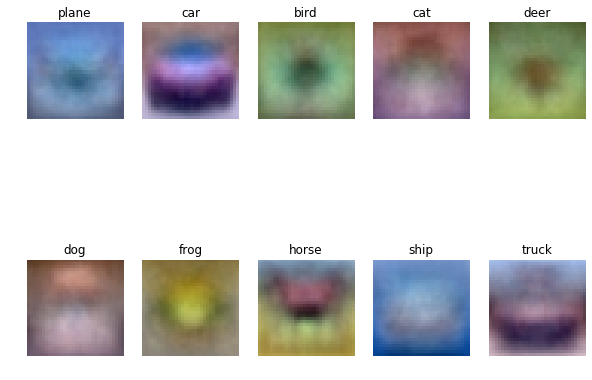

In [36]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])